# Hello

In [7]:
!pip uninstall numpy scikit-learn -y
!pip install numpy
!pip install scikit-learn

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: scikit-learn 1.5.1
Uninstalling scikit-learn-1.5.1:
  Successfully uninstalled scikit-learn-1.5.1
  Using cached numpy-2.4.2-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
Using cached numpy-2.4.2-cp312-cp312-win_amd64.whl (12.3 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cdlib 0.4.0 requires scikit-learn, which is not installed.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, which is not installed.
sentence-transformers 4.1.0 requires scikit-learn, which is not installed.
scipy 1.14.0 requires numpy<2.3,>=1.23.5, but you have numpy 2.4.2 which is incompatible.


  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------- ----------- 5.8/8.0 MB 35.1 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 26.1 MB/s  0:00:00
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.4.2

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-2.4.2:
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
      Successfully uninstalled numpy-2.4.2
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [n

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-whitegrid')

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
train = pd.read_csv('data/training_ALL.csv')

In [ ]:
submit = pd.read_csv('data/testing_ALL.csv')

In [ ]:
print(f"Training shape: {train.shape}")
print(f"Submission shape: {submit.shape}")
print(f"\nTraining columns:\n{list(train.columns)}")
print(f"\nSubmission columns:\n{list(submit.columns)}")

In [ ]:
# Target variables
TARGETS = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

# Key columns (not features)
KEYS = ['Latitude', 'Longitude', 'Sample Date']

# Columns to DROP (metadata, merge indicators, redundant)
DROP_COLS = [
    '_merge_terra',      # Merge indicator
    '_merge_landsat',    # Merge indicator
    'Impute_Method',     # Metadata
    'geometry',          # Geometry object (can't use directly)
    'STAT_ID',           # Station ID (use for grouping, not as feature)
    'date',              # GLORICH date (redundant with Sample Date)
    'Latitude_glorich',  # Redundant lat
    'Longitude_glorich', # Redundant lon
]

# GLORICH features (historical water quality from nearby stations)
GLORICH_FEATURES = [
    'Alkalinity', 'Cl', 'DIP', 'SO4', 'SpecCond25C', 'pH',
    'Alkalinity_reliability', 'Cl_reliability', 'DIP_reliability',
    'SO4_reliability', 'SpecCond25C_reliability', 'pH_reliability',
    'date_diff_days', 'dist_m', 'dist_km'
]

# Lithology features (rock types from GLiM)
LITHOLOGY_FEATURES = ['sc', 'ss', 'su', 'mt', 'va', 'vb', 'vi', 'pa', 'pb', 'pi']

# Land cover features
LANDCOVER_FEATURES = ['GLC_Artificial', 'GLC_Managed', 'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV']

# Remote sensing features
RS_FEATURES = ['pet', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI']

# Soil & population features
SOIL_POP_FEATURES = ['Popdens_00', 'Soil_pH', 'SOC', 'Soil_wetness']

# Combine all feature groups
ALL_FEATURE_GROUPS = {
    'GLORICH': GLORICH_FEATURES,
    'Lithology': LITHOLOGY_FEATURES,
    'Land Cover': LANDCOVER_FEATURES,
    'Remote Sensing': RS_FEATURES,
    'Soil & Population': SOIL_POP_FEATURES
}

print("Feature groups defined:")
for group, features in ALL_FEATURE_GROUPS.items():
    print(f"  {group}: {len(features)} features")

In [10]:
def preprocess(df, is_train=True):
    """Clean and preprocess dataframe"""
    df = df.copy()
    
    # Convert date
    df['Sample Date'] = pd.to_datetime(df['Sample Date'])
    
    # =========================================================================
    # TIME FEATURES
    # =========================================================================
    df['month'] = df['Sample Date'].dt.month
    df['day_of_year'] = df['Sample Date'].dt.dayofyear
    df['year'] = df['Sample Date'].dt.year
    df['quarter'] = df['Sample Date'].dt.quarter
    
    # Cyclic encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Season (South Africa: Oct-Mar = wet/summer)
    df['is_wet_season'] = df['month'].isin([10, 11, 12, 1, 2, 3]).astype(int)
    
    # =========================================================================
    # SPECTRAL RATIOS (if Landsat available)
    # =========================================================================
    if 'nir' in df.columns and 'green' in df.columns:
        df['nir_green_ratio'] = np.where(df['green'] > 0, df['nir'] / df['green'], np.nan)
        df['swir16_nir_ratio'] = np.where(df['nir'] > 0, df['swir16'] / df['nir'], np.nan)
        df['swir22_nir_ratio'] = np.where(df['nir'] > 0, df['swir22'] / df['nir'], np.nan)
        df['swir_ratio'] = np.where(df['swir22'] > 0, df['swir16'] / df['swir22'], np.nan)
        df['nir_minus_green'] = df['nir'] - df['green']
        df['swir_diff'] = df['swir16'] - df['swir22']
    
    # =========================================================================
    # SPATIAL FEATURES
    # =========================================================================
    df['lat_lon_interaction'] = df['Latitude'] * df['Longitude']
    df['dist_from_center'] = np.sqrt((df['Latitude'] + 29)**2 + (df['Longitude'] - 25)**2)
    
    # =========================================================================
    # GLORICH RELIABILITY-WEIGHTED FEATURES
    # =========================================================================
    # Weight GLORICH values by their reliability
    if 'Alkalinity' in df.columns and 'Alkalinity_reliability' in df.columns:
        df['Alkalinity_weighted'] = df['Alkalinity'] * df['Alkalinity_reliability']
        df['SpecCond_weighted'] = df['SpecCond25C'] * df['SpecCond25C_reliability']
        df['DIP_weighted'] = df['DIP'] * df['DIP_reliability']
        df['pH_weighted'] = df['pH'] * df['pH_reliability']
    
    # =========================================================================
    # INTERACTION FEATURES
    # =========================================================================
    # Lithology-Landcover interactions (geology affects runoff)
    if 'GLC_Artificial' in df.columns:
        # Total lithology diversity
        lith_cols = [c for c in LITHOLOGY_FEATURES if c in df.columns]
        df['lithology_diversity'] = (df[lith_cols] > 0).sum(axis=1)
        
        # Artificial land with carbonate rock
        df['artificial_carbonate'] = df['GLC_Artificial'] * df.get('sc', 0)
        
        # Agricultural pressure proxy
        df['managed_pop_pressure'] = df['GLC_Managed'] * np.log1p(df.get('Popdens_00', 0))
    
    # =========================================================================
    # DROP UNWANTED COLUMNS
    # =========================================================================
    cols_to_drop = [c for c in DROP_COLS if c in df.columns]
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    return df

In [11]:
train_processed = preprocess(train, is_train=True)
submit_processed = preprocess(submit, is_train=False)

print(f"Training after preprocessing: {train_processed.shape}")
print(f"Submission after preprocessing: {submit_processed.shape}")

NameError: name 'train' is not defined

In [12]:
# Get feature columns (everything except targets and keys)
feature_cols = [c for c in train_processed.columns 
                if c not in TARGETS + KEYS + ['Sample Date']]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns:\n{feature_cols}")

NameError: name 'train_processed' is not defined

In [13]:
# Prepare X and y
X_train = train_processed[feature_cols].copy()
y_train = train_processed[TARGETS].copy()

# Check if submission has all features
missing_in_submit = [c for c in feature_cols if c not in submit_processed.columns]
if missing_in_submit:
    print(f"⚠️ Missing in submission: {missing_in_submit}")
    # Add missing columns with NaN
    for col in missing_in_submit:
        submit_processed[col] = np.nan

X_submit = submit_processed[feature_cols].copy()
# note: need to add submission preprocessing
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

NameError: name 'train_processed' is not defined

In [14]:
print("\n--- Missing Values in Training Features ---")
missing = X_train.isnull().sum()
missing_pct = (missing / len(X_train) * 100).round(1)
missing_df = pd.DataFrame({'count': missing, 'pct': missing_pct})
print(missing_df[missing_df['count'] > 0].sort_values('pct', ascending=False))

# %%
# Fill missing values with median (robust to outliers)
train_medians = X_train.median()
X_train_filled = X_train.fillna(train_medians)
X_submit_filled = X_submit.fillna(train_medians)

print(f"\n✓ Missing values filled with training medians")
print(f"  Remaining NaN in X_train: {X_train_filled.isnull().sum().sum()}")
print(f"  Remaining NaN in X_submit: {X_submit_filled.isnull().sum().sum()}")


--- Missing Values in Training Features ---


NameError: name 'X_train' is not defined

In [15]:
# Create spatial clusters for GroupKFold CV
# This prevents geographic leakage (nearby stations shouldn't be in same fold)

coords = train_processed[['Latitude', 'Longitude']].values
n_clusters = 15  # More clusters = stricter spatial separation

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
spatial_clusters = kmeans.fit_predict(coords)

print(f"Spatial clusters created: {n_clusters} clusters")
print(f"Cluster distribution:\n{pd.Series(spatial_clusters).value_counts().sort_index()}")

NameError: name 'train_processed' is not defined

NameError: name 'coords' is not defined

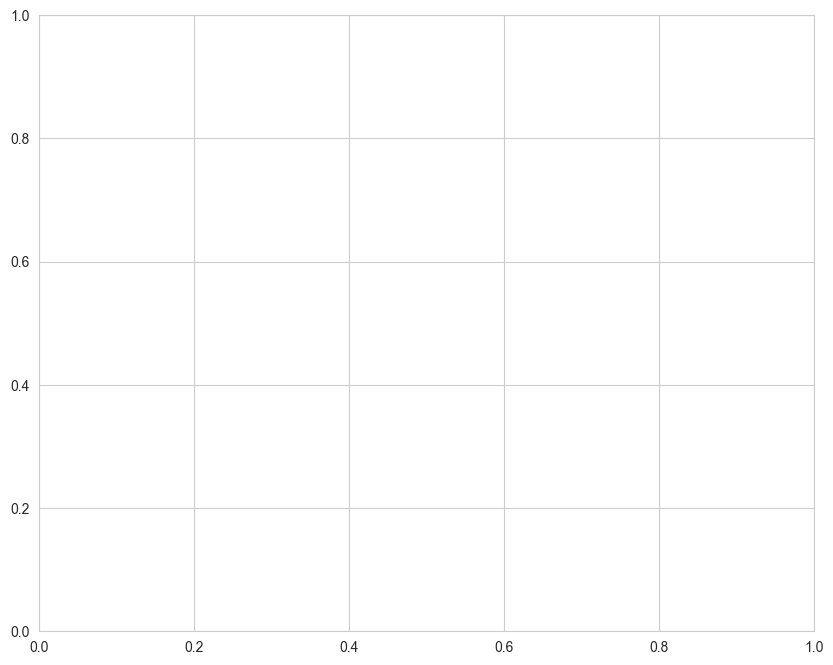

In [16]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(coords[:, 1], coords[:, 0], c=spatial_clusters, cmap='tab20', alpha=0.6, s=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial Clusters for Cross-Validation')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.savefig('spatial_clusters.png', dpi=150)
plt.show()

In [ ]:
N_FOLDS = 5
gkf = GroupKFold(n_splits=N_FOLDS)


## Training tree-based models 

In [ ]:
def evaluate_model(y_true, y_pred, target_name):
    """Calculate evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'target': target_name, 'R2': r2, 'RMSE': rmse, 'MAE': mae}

def train_and_evaluate(model_class, model_params, X, y, groups, target_name, apply_log=False):
    """Train model with spatial CV and return metrics + feature importance"""
    
    fold_metrics = []
    fold_importances = []
    oof_preds = np.zeros(len(X))
    
    y_transformed = np.log1p(y) if apply_log else y
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y_transformed, groups)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y_transformed.iloc[train_idx], y_transformed.iloc[val_idx]
        
        model = model_class(**model_params)
        
        # Handle different model types
        if 'catboost' in str(model_class).lower():
            model.fit(X_tr, y_tr, verbose=0)
        else:
            model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        oof_preds[val_idx] = preds
        
        # Inverse transform for metrics
        if apply_log:
            preds_orig = np.expm1(preds)
            y_val_orig = np.expm1(y_val)
        else:
            preds_orig = preds
            y_val_orig = y_val
        
        metrics = evaluate_model(y_val_orig, preds_orig, target_name)
        metrics['fold'] = fold + 1
        fold_metrics.append(metrics)
        
        # Feature importance
        fold_importances.append(model.feature_importances_)
    
    # Average importance across folds
    avg_importance = np.mean(fold_importances, axis=0)
    
    # OOF metrics
    if apply_log:
        oof_metrics = evaluate_model(y, np.expm1(oof_preds), target_name)
    else:
        oof_metrics = evaluate_model(y, oof_preds, target_name)
    
    return {
        'fold_metrics': pd.DataFrame(fold_metrics),
        'oof_metrics': oof_metrics,
        'importance': avg_importance,
        'oof_preds': np.expm1(oof_preds) if apply_log else oof_preds
    }


## Baseline: LightGBM model

In [ ]:
print("="*70)
print("TRAINING LIGHTGBM MODELS")
print("="*70)

lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

lgbm_results = {}

for target in TARGETS:
    print(f"\n{'─'*50}")
    print(f"Target: {target}")
    print(f"{'─'*50}")
    
    y = y_train[target]
    
    # Apply log transform for DRP (heavily skewed)
    apply_log = 'Phosphorus' in target
    if apply_log:
        print("  → Applying log1p transform")
    
    results = train_and_evaluate(
        LGBMRegressor, 
        lgbm_params,
        X_train_filled, 
        y, 
        spatial_clusters,
        target,
        apply_log=apply_log
    )
    
    lgbm_results[target] = results
    
    # Print fold metrics
    print(f"\n  Fold Results:")
    print(results['fold_metrics'][['fold', 'R2', 'RMSE', 'MAE']].to_string(index=False))
    
    # Print OOF metrics
    print(f"\n  OOF R²: {results['oof_metrics']['R2']:.4f}")
    print(f"  OOF RMSE: {results['oof_metrics']['RMSE']:.2f}")

# Summary
print("\n" + "="*70)
print("LIGHTGBM CROSS-VALIDATION SUMMARY")
print("="*70)

summary_data = []
for target, results in lgbm_results.items():
    fold_df = results['fold_metrics']
    summary_data.append({
        'Target': target,
        'Mean R²': fold_df['R2'].mean(),
        'Std R²': fold_df['R2'].std(),
        'Mean RMSE': fold_df['RMSE'].mean(),
        'OOF R²': results['oof_metrics']['R2']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

mean_r2 = summary_df['OOF R²'].mean()
print(f"\n*** MEAN R² ACROSS ALL TARGETS: {mean_r2:.4f} ***")

### feature importance analysis 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, target in enumerate(TARGETS):
    importance = lgbm_results[target]['importance']
    
    # Get top 20 features
    sorted_idx = np.argsort(importance)[-20:]
    
    ax = axes[idx]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_idx)))
    ax.barh(range(len(sorted_idx)), importance[sorted_idx], color=colors)
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_cols[i] for i in sorted_idx], fontsize=9)
    ax.set_xlabel('Importance', fontsize=10)
    
    # Shorten title
    short_name = target.replace('Dissolved Reactive ', '').replace('Electrical ', '')
    ax.set_title(f'{short_name}\nTop 20 Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_lgbm.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature importance plot saved to feature_importance_lgbm.png")

In [17]:
importance_summary = pd.DataFrame({'feature': feature_cols})

for target in TARGETS:
    short_name = target.split()[0]  # First word
    importance_summary[f'{short_name}_imp'] = lgbm_results[target]['importance']

# Add rank columns
for target in TARGETS:
    short_name = target.split()[0]
    importance_summary[f'{short_name}_rank'] = importance_summary[f'{short_name}_imp'].rank(ascending=False).astype(int)

# Average importance
imp_cols = [c for c in importance_summary.columns if '_imp' in c]
importance_summary['avg_importance'] = importance_summary[imp_cols].mean(axis=1)
importance_summary['avg_rank'] = importance_summary['avg_importance'].rank(ascending=False).astype(int)

# Sort by average importance
importance_summary = importance_summary.sort_values('avg_importance', ascending=False)

print("\n--- TOP 25 MOST IMPORTANT FEATURES (averaged across targets) ---")
print(importance_summary[['feature', 'avg_importance', 'avg_rank']].head(25).to_string(index=False))

# Save full importance table
importance_summary.to_csv('feature_importance_summary.csv', index=False)
print("\n✓ Full importance table saved to feature_importance_summary.csv")

NameError: name 'feature_cols' is not defined

## Comparison with other tree models 

In [18]:
print("\n" + "="*70)
print("COMPARING TREE-BASED MODELS")
print("="*70)

# Models to compare
models_to_compare = {
    'LightGBM': (LGBMRegressor, {
        'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42, 'verbose': -1
    }),
    'XGBoost': (XGBRegressor, {
        'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42, 'verbosity': 0
    }),
    'RandomForest': (RandomForestRegressor, {
        'n_estimators': 200, 'max_depth': 15, 'random_state': 42, 'n_jobs': -1
    }),
    'ExtraTrees': (ExtraTreesRegressor, {
        'n_estimators': 200, 'max_depth': 15, 'random_state': 42, 'n_jobs': -1
    }),
    'GradientBoosting': (GradientBoostingRegressor, {
        'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42
    })
}

comparison_results = []

for model_name, (model_class, params) in models_to_compare.items():
    print(f"\n--- {model_name} ---")
    
    for target in TARGETS:
        y = y_train[target]
        apply_log = 'Phosphorus' in target
        
        results = train_and_evaluate(
            model_class, params, X_train_filled, y, 
            spatial_clusters, target, apply_log=apply_log
        )
        
        comparison_results.append({
            'Model': model_name,
            'Target': target.split()[0],  # Shortened name
            'R2': results['oof_metrics']['R2'],
            'RMSE': results['oof_metrics']['RMSE']
        })
        
        print(f"  {target.split()[0]}: R² = {results['oof_metrics']['R2']:.4f}")

# Create comparison table
comparison_df = pd.DataFrame(comparison_results)
comparison_pivot = comparison_df.pivot(index='Model', columns='Target', values='R2')
comparison_pivot['Mean R²'] = comparison_pivot.mean(axis=1)
comparison_pivot = comparison_pivot.sort_values('Mean R²', ascending=False)

print("\n" + "="*70)
print("MODEL COMPARISON (OOF R² by Target)")
print("="*70)
print(comparison_pivot.round(4).to_string())


COMPARING TREE-BASED MODELS


NameError: name 'LGBMRegressor' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
comparison_pivot.drop('Mean R²', axis=1).plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('R² Score')
ax.set_title('Model Comparison: R² by Target (Spatial CV)')
ax.set_xticklabels(comparison_pivot.index, rotation=45, ha='right')
ax.legend(title='Target', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# training final prediction 

In [19]:
print("\n" + "="*70)
print("TRAINING FINAL MODELS ON ALL DATA")
print("="*70)

# Use LightGBM (or best model from comparison)
final_models = {}
final_predictions = {}

for target in TARGETS:
    print(f"\nTraining final model for: {target}")
    
    y = y_train[target]
    apply_log = 'Phosphorus' in target
    
    if apply_log:
        y_transformed = np.log1p(y)
    else:
        y_transformed = y
    
    # Train on full data with LightGBM
    model = XGBRegressor(
        n_estimators=600,          # More iterations for final
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    )
    model.fit(X_train_filled, y_transformed)
    
    # Predict on submission set
    preds = model.predict(X_submit_filled)
    
    if apply_log:
        preds = np.expm1(preds)
    
    # Clip to reasonable range (based on training data)
    train_min = y.min()
    train_max = y.max()
    preds = np.clip(preds, train_min * 0.5, train_max * 1.5)
    
    final_models[target] = model
    final_predictions[target] = preds
    
    print(f"  Predictions - Min: {preds.min():.2f}, Max: {preds.max():.2f}, Mean: {preds.mean():.2f}")


TRAINING FINAL MODELS ON ALL DATA


NameError: name 'TARGETS' is not defined

## create submission file 

In [ ]:
# Create submission dataframe
submission = pd.DataFrame({
    'Latitude': submit_processed['Latitude'],
    'Longitude': submit_processed['Longitude'],
    'Sample Date': submit_processed['Sample Date'].dt.strftime('%Y-%m-%d') if hasattr(submit_processed['Sample Date'], 'dt') else submit_processed['Sample Date'],
    'Total Alkalinity': final_predictions['Total Alkalinity'],
    'Electrical Conductance': final_predictions['Electrical Conductance'],
    'Dissolved Reactive Phosphorus': final_predictions['Dissolved Reactive Phosphorus']
})

In [20]:
!pip install iPython

In [21]:
from IPython.display import FileLink 

# FileLink(r'data/submission_predictions.csv')

In [22]:
FileLink('data/submission_predictions.csv')

C:\Users\knich\OneDrive\Documents\GitHub\EY_DataThon2026\data\submission_predictions.csv

In [23]:
# Save
submission.to_csv('data/submission_predictions.csv', index=False)
FileLink(r'data/submission_predictions.csv')
print("\n✓ Submission saved to submission_predictions.csv")
print(f"\nSubmission shape: {submission.shape}")
print("\nSubmission preview:")
print(submission.head(10))

NameError: name 'submission' is not defined

In [ ]:
# Compare prediction distributions to training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(TARGETS):
    ax = axes[idx]
    
    # Training distribution
    ax.hist(y_train[target], bins=50, alpha=0.5, label='Training', density=True)
    # Prediction distribution
    ax.hist(final_predictions[target], bins=50, alpha=0.5, label='Predictions', density=True)
    
    short_name = target.replace('Dissolved Reactive ', 'DRP\n').replace('Electrical ', 'EC\n')
    ax.set_title(short_name)
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.savefig('prediction_distributions.png', dpi=150)
plt.show()

print("✓ Distribution comparison saved to prediction_distributions.png")